In [3]:
# "tommy/from_clement"

# Explore data from Clement

In [4]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [5]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [6]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [7]:
EXPERIMENT =      'one_month_forecast_BASE_static_vars'
TRUE_EXPERIMENT = 'one_month_forecast'
TARGET_VAR =      'boku_VCI'

# read in excel data

In [13]:
files = [f for f in (data_dir / "tommy/from_clement/VCI_data_Kenya").iterdir()]
files

[PosixPath('data/tommy/from_clement/VCI_data_Kenya/2002_2019_reg1_NDVIBw_VCI1M_VCI3M_all.xlsx'),
 PosixPath('data/tommy/from_clement/VCI_data_Kenya/2002_2019_reg1_NDVIBw_VCI1M_VCI3M_pastoral.xlsx')]

In [164]:
def create_region_colnames(column_labels: pd.DataFrame) -> pd.DataFrame:
    column_labels = column_labels.T
    column_labels.columns = column_labels.iloc[0, :].values
    column_labels = column_labels.iloc[1:, :]
    column_labels['county'] = column_labels.county * 10

    column_labels['constituency_id'] = column_labels.county + column_labels.Subcounty
    return column_labels


def read_sheet_data(excel_filepath: Path, sheet_name: str) -> pd.DataFrame():
    # read in the data
    df = pd.read_excel(excel_filepath, sheet_name=sheet_name, header=None)
    column_labels = df.iloc[:2, :]
    assert all(np.isin(['county', 'Subcounty'], column_labels.iloc[:, 0].values))
    
    df = df.iloc[3:, :].rename(columns={0: 'time'})

    # create datetime index
    df['time'] = df.time.apply(lambda x: pd.to_datetime(x, format='%Y%m'))
    df = df.set_index('time')
    
    column_labels = create_region_colnames(column_labels)
    df.columns = column_labels.constituency_id
    
    return df


def convert_to_long_format(df, sheet_name) -> pd.DataFrame:
    var_name = sheet_name.split('_')[0].lower()
    long_format = (
        pd.melt(df.reset_index(), id_vars=['time'])
        .rename(columns={'value': var_name})
    )
    long_format['region_id'] = long_format.constituency_id // 10
    long_format = long_format.set_index(['time', 'constituency_id'])
    
    return long_format


def process_sheet_data(excel_filepath: Path, sheet_name: str) -> xr.Dataset:
    print(f"Preprocessing {sheet_name}")
    df = read_sheet_data(excel_filepath, sheet_name=sheet_name)
    long_format = convert_to_long_format(df=df, sheet_name=sheet_name)
    ds = long_format.to_xarray()
    
    return ds


def preprocess_excel_file(excel_filepath: Path, sheet_names: List = ['NDVI1W_AVE', 'VCI1M_AVE', 'VCI3M_AVE']) -> Tuple[xr.Dataset, pd.DataFrame]:
    # 1. read in the region_lookup data
    region_lookup = pd.read_excel(excel_filepath, sheet_name='Description', skiprows=3).iloc[:, 4:8]
    assert all(np.isin(['reg0_id', 'reg0_name', 'reg1_id', 'reg1_name'], region_lookup.columns))
    
    # 2. process sheet data
    all_ds = []
    for sheet_name in sheet_names:
        all_ds.append(
            process_sheet_data(excel_filepath=excel_filepath, sheet_name=sheet_name)
         )
    
    ds = xr.auto_combine(all_ds)
    
    return ds, region_lookup


# TODO: fix the creation of the lookup dataframe for column names
print(files[0])
ds, region_lookup = preprocess_excel_file(files[0])

data/tommy/from_clement/VCI_data_Kenya/2002_2019_reg1_NDVIBw_VCI1M_VCI3M_all.xlsx
Preprocessing NDVI1W_AVE
Preprocessing VCI1M_AVE
Preprocessing VCI3M_AVE


In [165]:
ds

<xarray.Dataset>
Dimensions:          (constituency_id: 265, time: 215)
Coordinates:
  * time             (time) datetime64[ns] 2002-02-01 2002-03-01 ... 2019-12-01
  * constituency_id  (constituency_id) float64 11.0 12.0 13.0 ... 475.0 476.0
Data variables:
    ndvi1w           (time, constituency_id) float64 0.53 0.39 ... 0.65 0.65
    region_id        (time, constituency_id) object 1.0 1.0 1.0 ... 47.0 47.0
    vci1m            (time, constituency_id) float64 36.63 22.72 ... 77.08 81.95
    vci3m            (time, constituency_id) float64 44.45 31.11 ... 73.69 70.94

In [166]:
ds.to_netcdf(data_dir / 'tommy/clement_VegInd_ds.nc')
region_lookup.to_csv(data_dir / 'tommy/clement_region_lookup.csv')

# get other datasets

In [155]:
def wget_file(parent_dir: Path, url_path: str) -> None:
    output_file = parent_dir / url_path.split("/")[-1]
    if output_file.exists():
        print(f"{output_file} already exists! Skipping")
        return None
    os.system(f"wget {url_path} -P {parent_dir.as_posix()}")


chirps_all_url = "https://bokubox.boku.ac.at/index.php/get/a98e6710acfa17631e9f2a961226e6fd/2002_2019_reg1_CHIRPS_all.xlsx"
# "https://bokubox.boku.ac.at/index.php/get/3e1efb60396aa9cd31ff955caed76f6f/2002_2019_reg1_CHIRPS_past.xlsx"
ndvi_all_url = "https://bokubox.boku.ac.at/index.php/get/7c794a7fd2db026fb2f024b2bbcfacfe/2002_2019_reg1_MCD09Q1_all.xlsx"
# "https://bokubox.boku.ac.at/index.php/get/14ace5b75e8bcda276c33fa451879e5e/2002_2019_reg1_MCD09Q1_pastoral.xlsx"
tamsat_all_url = "https://bokubox.boku.ac.at/index.php/get/a9326daf7b2a1529f0e0a0fd76ce96aa/2002_2019_reg1_TAMSAT_all.xlsx"
# "https://bokubox.boku.ac.at/index.php/get/b524fe300029a650eca748d3d9fbf07d/2002_2019_reg1_TAMSAT_past.xlsx"

In [157]:
(data_dir / "tommy/from_clement/other_vars").mkdir(exist_ok=True)

parent_dir = (data_dir / "tommy/from_clement/other_vars")
for url_path in [chirps_all_url, ndvi_all_url, tamsat_all_url]:
    wget_file(parent_dir, url_path)
    
[f for f in parent_dir.iterdir()]

data/tommy/from_clement/other_vars/2002_2019_reg1_CHIRPS_all.xlsx already exists! Skipping
data/tommy/from_clement/other_vars/2002_2019_reg1_MCD09Q1_all.xlsx already exists! Skipping
data/tommy/from_clement/other_vars/2002_2019_reg1_TAMSAT_all.xlsx already exists! Skipping


[PosixPath('data/tommy/from_clement/other_vars/2002_2019_reg1_CHIRPS_all.xlsx'),
 PosixPath('data/tommy/from_clement/other_vars/2002_2019_reg1_TAMSAT_all.xlsx'),
 PosixPath('data/tommy/from_clement/other_vars/2002_2019_reg1_MCD09Q1_all.xlsx')]

In [167]:
from collections import namedtuple

CSVFiles = namedtuple('csv_files', ['filepath', 'sheets'])

tamsat_data = CSVFiles(
    filepath=(data_dir / "tommy/from_clement/other_vars/2002_2019_reg1_TAMSAT_all.xlsx"),
    sheets=[
        'RFE1M_AVE',
        'RFE3M_AVE',
        'RFE6M_AVE',
        'RCI1M_AVE',
        'RCI3M_AVE',
        'RCI6M_AVE',
        'SPI1M_AVE',
        'SPI3M_AVE',
        'SPI6M_AVE',
    ]
)

chirps_data = CSVFiles(
    filepath=(data_dir / "tommy/from_clement/other_vars/2002_2019_reg1_CHIRPS_all.xlsx"),
    sheets=[
        'RFE1M_AVE',
        'RFE3M_AVE',
        'RFE6M_AVE',
        'RCI1M_AVE',
        'RCI3M_AVE',
        'RCI6M_AVE',
        'SPI1M_AVE',
        'SPI3M_AVE',
        'SPI6M_AVE',
    ]
)

modis_ndvi_data = CSVFiles(
    filepath=(data_dir / "tommy/from_clement/other_vars/2002_2019_reg1_MCD09Q1_all.xlsx"),
    sheets=[
        'NDVI1W_AVE',
        'VCI1W_AVE',
        'VCI1M_AVE',
        'VCI3M_AVE',
        'ZVI1W_AVE',
        'ZVI1M_AVE',
        'ZVI3M_AVE',
        'DMmax',
    ]
)

In [168]:
tamsat_ds, region_lookup = preprocess_excel_file(tamsat_data.filepath, tamsat_data.sheets)
chirps_ds, _ = preprocess_excel_file(chirps_data.filepath, chirps_data.sheets)
modis_ndvi_ds, _ = preprocess_excel_file(modis_ndvi_data.filepath, modis_ndvi_data.sheets)

Preprocessing RFE1M_AVE
Preprocessing RFE3M_AVE
Preprocessing RFE6M_AVE
Preprocessing RCI1M_AVE
Preprocessing RCI3M_AVE
Preprocessing RCI6M_AVE
Preprocessing SPI1M_AVE
Preprocessing SPI3M_AVE
Preprocessing SPI6M_AVE
Preprocessing RFE1M_AVE
Preprocessing RFE3M_AVE
Preprocessing RFE6M_AVE
Preprocessing RCI1M_AVE
Preprocessing RCI3M_AVE
Preprocessing RCI6M_AVE
Preprocessing SPI1M_AVE
Preprocessing SPI3M_AVE
Preprocessing SPI6M_AVE
Preprocessing NDVI1W_AVE
Preprocessing VCI1W_AVE
Preprocessing VCI1M_AVE
Preprocessing VCI3M_AVE
Preprocessing ZVI1W_AVE
Preprocessing ZVI1M_AVE
Preprocessing ZVI3M_AVE
Preprocessing DMmax


In [169]:
tamsat_ds.to_netcdf(data_dir / 'tommy/clement_tamsat_ds.nc')
chirps_ds.to_netcdf(data_dir / 'tommy/clement_chirps_ds.nc')
modis_ndvi_ds.to_netcdf(data_dir / 'tommy/clement_ndvi_ds.nc')

In [172]:
modis_ndvi_ds

<xarray.Dataset>
Dimensions:          (constituency_id: 265, time: 215)
Coordinates:
  * time             (time) datetime64[ns] 2002-02-01 2002-03-01 ... 2019-12-01
  * constituency_id  (constituency_id) float64 11.0 12.0 13.0 ... 475.0 476.0
Data variables:
    dmmax            (time, constituency_id) float64 40.93 61.01 ... 22.74 21.04
    region_id        (time, constituency_id) object 1.0 1.0 1.0 ... 47.0 47.0
    ndvi1w           (time, constituency_id) float64 0.53 0.39 ... 0.65 0.65
    vci1m            (time, constituency_id) float64 36.63 22.72 ... 77.08 81.95
    vci1w            (time, constituency_id) float64 36.8 22.95 ... 76.71 81.52
    vci3m            (time, constituency_id) float64 44.45 31.11 ... 73.69 70.94
    zvi1m            (time, constituency_id) float64 -0.32 -0.55 ... 0.79 0.93
    zvi1w            (time, constituency_id) float64 -0.47 -0.75 ... 1.16 1.39
    zvi3m            (time, constituency_id) float64 -0.27 -0.47 ... 0.89 0.78

# marginalia

In [140]:
# get regions (columns)
region_lookup = pd.read_excel(files[0], sheet_name='Description', skiprows=3).iloc[:, 4:8]
region_lookup.head()

,reg0_id,reg0_name,reg1_id,reg1_name
0,10,Baringo,11,Baringo Central
1,10,Baringo,12,Baringo North
2,10,Baringo,13,Baringo South
3,10,Baringo,14,Eldama Ravine
4,10,Baringo,15,Mogotio


In [141]:
# read in the data
ndvi_df = pd.read_excel(files[0], sheet_name='NDVI1W_AVE', header=None)
column_labels = ndvi_df.iloc[:2, :]
ndvi_df = ndvi_df.iloc[3:, :].rename(columns={0: 'time'})

# create datetime index
ndvi_df['time'] = ndvi_df.time.apply(lambda x: pd.to_datetime(x, format='%Y%m'))
ndvi_df = ndvi_df.set_index('time')

ndvi_df.head()

,1,2,3,4,5,6,7,8,9,10,...,256,257,258,259,260,261,262,263,264,265
time,,,,,,,,,,,,,,,,,,,,,
2002-02-01,0.53,0.39,0.37,0.64,0.42,0.30,0.68,0.64,0.67,0.77,...,0.30,0.32,0.45,0.37,0.64,0.68,0.51,0.68,0.58,0.59
2002-03-01,0.52,0.39,0.39,0.60,0.41,0.31,0.68,0.68,0.69,0.74,...,0.33,0.34,0.44,0.37,0.69,0.69,0.53,0.69,0.62,0.62
2002-04-01,0.56,0.42,0.47,0.64,0.51,0.38,0.78,0.72,0.71,0.79,...,0.42,0.43,0.52,0.47,0.71,0.71,0.51,0.67,0.59,0.55
2002-05-01,0.62,0.50,0.55,0.70,0.61,0.47,0.81,0.76,0.75,0.83,...,0.53,0.53,0.59,0.57,0.74,0.74,0.57,0.70,0.61,0.60
2002-06-01,0.65,0.53,0.52,0.71,0.56,0.48,0.77,0.71,0.68,0.81,...,0.55,0.55,0.60,0.53,0.67,0.71,0.65,0.73,0.68,0.64


In [142]:
if [c for c in column_labels.columns] != ['county', 'Subcounty']:
    column_labels = column_labels.T
    column_labels.columns = column_labels.iloc[0, :].values
    column_labels = column_labels.iloc[1:, :]
    column_labels['county'] = column_labels.county * 10

column_labels['constituency_id'] = column_labels.county + column_labels.Subcounty
column_labels.head()
# columns = column_labels.apply(lambda x: x.county x.subcounty, axis=1)

,county,Subcounty,constituency_id
1,10,1,11
2,10,2,12
3,10,3,13
4,10,4,14
5,10,5,15


In [143]:
# set column labels to the constituency_ids
ndvi_df.columns = column_labels.constituency_id  # region = column_labels.constituency_id // 10
ndvi_df.head()

constituency_id,11.0,12.0,13.0,14.0,15.0,16.0,21.0,22.0,23.0,24.0,...,461.0,462.0,463.0,464.0,471.0,472.0,473.0,474.0,475.0,476.0
time,,,,,,,,,,,,,,,,,,,,,
2002-02-01,0.53,0.39,0.37,0.64,0.42,0.30,0.68,0.64,0.67,0.77,...,0.30,0.32,0.45,0.37,0.64,0.68,0.51,0.68,0.58,0.59
2002-03-01,0.52,0.39,0.39,0.60,0.41,0.31,0.68,0.68,0.69,0.74,...,0.33,0.34,0.44,0.37,0.69,0.69,0.53,0.69,0.62,0.62
2002-04-01,0.56,0.42,0.47,0.64,0.51,0.38,0.78,0.72,0.71,0.79,...,0.42,0.43,0.52,0.47,0.71,0.71,0.51,0.67,0.59,0.55
2002-05-01,0.62,0.50,0.55,0.70,0.61,0.47,0.81,0.76,0.75,0.83,...,0.53,0.53,0.59,0.57,0.74,0.74,0.57,0.70,0.61,0.60
2002-06-01,0.65,0.53,0.52,0.71,0.56,0.48,0.77,0.71,0.68,0.81,...,0.55,0.55,0.60,0.53,0.67,0.71,0.65,0.73,0.68,0.64


In [144]:
# to long format (then to xarray)
long_format = pd.melt(ndvi_df.reset_index(), id_vars=['time']).rename(columns={'value': 'ndvi'})
long_format['region_id'] = long_format.constituency_id // 10
long_format = long_format.set_index(['time', 'constituency_id'])

ds = long_format.to_xarray()

In [145]:
ds

<xarray.Dataset>
Dimensions:          (constituency_id: 265, time: 215)
Coordinates:
  * time             (time) datetime64[ns] 2002-02-01 2002-03-01 ... 2019-12-01
  * constituency_id  (constituency_id) float64 11.0 12.0 13.0 ... 475.0 476.0
Data variables:
    ndvi             (time, constituency_id) float64 0.53 0.39 ... 0.65 0.65
    region_id        (time, constituency_id) object 1.0 1.0 1.0 ... 47.0 47.0

Text(0.5, 1.0, 'Constituency: 11 NDVI')

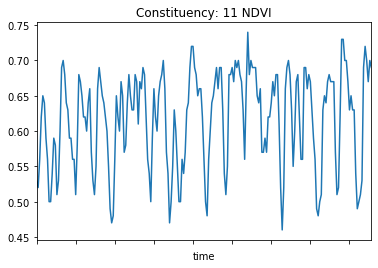

In [148]:
constituency_id = 11

fig, ax = plt.subplots()
long_format.query(f'constituency_id == {constituency_id}').ndvi.plot(ax=ax)
ax.set_xlabel('time')
ax.set_xticklabels(['']);
ax.set_title(f"Constituency: {constituency_id} NDVI");

for item in 